In [5]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>")) 

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Plots for Synchronous SGD

In [2]:
lines = []
with open('log_sync.log', 'r') as log_file:
    # Iterate through each line in the log file
    for line in log_file:
        lines.append(line.split(" - __mp_main__ - "))
        
for i, line in enumerate(lines):
    timestamp = datetime.strptime(line[0], '%Y-%m-%d %H:%M:%S,%f')
    lines[i][0] = timestamp

nb_workers = int((lines[0][1].split("with ")[1]).split(" workers")[0]) # extract from first line
lines = lines[1:-1] # remove first and last lines (info messages)

start_time = lines[0][0]
end_time = lines[-1][0]
training_time = end_time - start_time

minutes, remainder = divmod(training_time.seconds, 60)
seconds = remainder
milliseconds = training_time.microseconds // 1000
formatted_training_time = f"{minutes:02d}:{seconds:02d}:{milliseconds:03d}"
print("Training time:", formatted_training_time) # MM:SS:sss

for i, line in enumerate(lines):
    lines[i][0] = line[0] - start_time
    lines[i][1] = line[1].split("DEBUG - ")[1].strip()
    
model_loss_lines = []
worker_update_lines = []
for i, line in enumerate(lines):
    if i < nb_workers:
        continue
    if "PS updated model, " in line[1]:
        #timedetla, model loss
        model_loss_lines.append((line[0], float(line[1].split("is ")[1])))
    elif "PS got " in line[1]:
        splited_text = (line[1].split("from ")[1]).split(" ")
        #timedelta, worker id, batch count, epoch
        worker_update_lines.append((line[0], int(splited_text[0].split("_")[1][:-1]), int(splited_text[2].split("/")[0][1:]), int(splited_text[-1].split("/")[0])))

Training time: 02:30:051


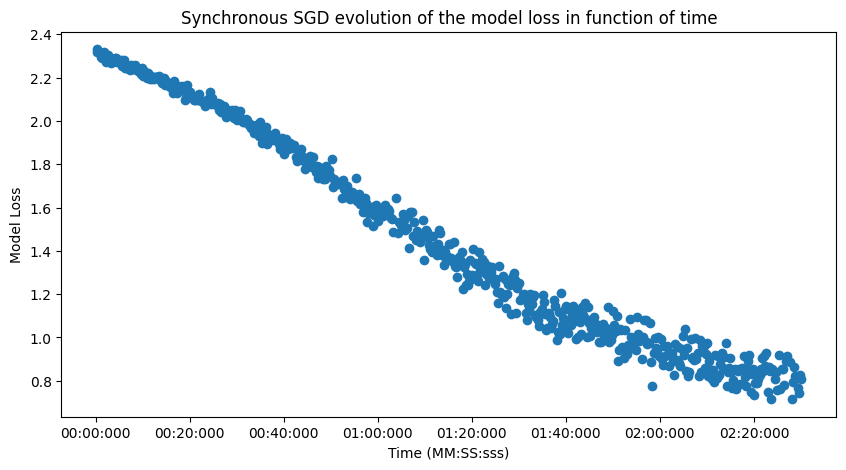

In [6]:
def format_timedelta(x, pos):
    td = timedelta(seconds=x)
    minutes, remainder = divmod(td.seconds, 60)
    seconds = remainder
    milliseconds = td.microseconds // 1000
    return f"{minutes:02d}:{seconds:02d}:{milliseconds:03d}"

# Extract timedelta and loss values from model_loss_lines
timedeltas = [line[0].total_seconds() for line in model_loss_lines]
losses = [line[1] for line in model_loss_lines]

# Create the plot
plt.figure(figsize=(10, 5))
plt.scatter(timedeltas, losses, marker='o')
plt.xlabel('Time (MM:SS:sss)')
plt.ylabel('Model Loss')
plt.title('Synchronous SGD evolution of the model loss in function of time')

# Format x-axis tick labels
formatter = FuncFormatter(format_timedelta)
plt.gca().xaxis.set_major_formatter(formatter)

# Display the plot
plt.show()

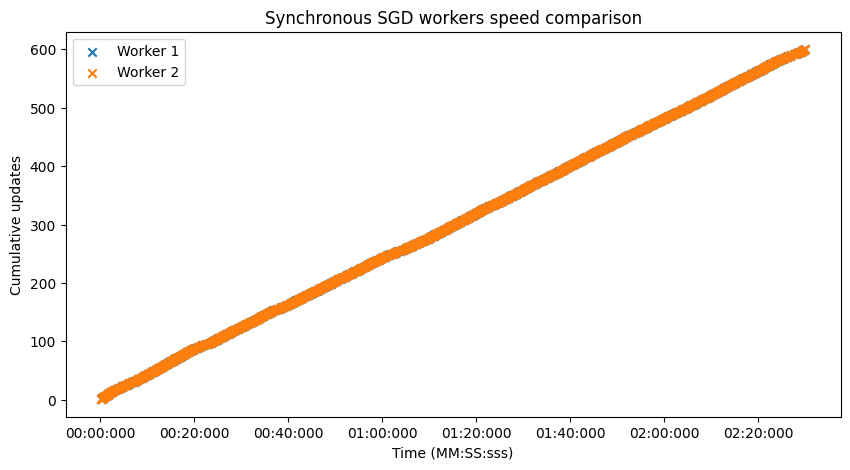

In [4]:
worker_cumulative_updates = {}
for line in worker_update_lines:
    td, worker_id, batch_count, epoch = line
    worker_cumulative_updates.setdefault(worker_id, []).append((td, batch_count))

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
for worker_id, updates in worker_cumulative_updates.items():
    x = [td.total_seconds() for td, _ in updates]
    y = [batch_count for _, batch_count in updates]
    ax.scatter(x, y, label=f'Worker {worker_id}', marker='x')

ax.set_xlabel('Time (MM:SS:sss)')
ax.set_ylabel('Cumulative updates')
ax.set_title('Synchronous SGD workers speed comparison')
ax.legend()

# Format x-axis tick labels
formatter = FuncFormatter(format_timedelta)
plt.gca().xaxis.set_major_formatter(formatter)

plt.show()

# Plot for Asynchronous SGD

In [ ]:
def extract_info_async(logfile):
    time_pattern = re.compile(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}")
    worker_pattern = re.compile(r"PS got update from Worker_(\d)")

    worker_updates = {1: [], 2: []}
    first_timestamp = None

    with open(logfile, 'r') as f:
        for line in f:
            time_match = time_pattern.search(line)
            worker_match = worker_pattern.search(line)

            if time_match:
                timestamp = datetime.datetime.strptime(time_match.group(), "%Y-%m-%d %H:%M:%S,%f")
                if first_timestamp is None:
                    first_timestamp = timestamp
                timestamp = (timestamp - first_timestamp).total_seconds()

            if worker_match:
                worker_id = int(worker_match.group(1))
                worker_updates[worker_id].append(timestamp)

    return worker_updates

def plot_worker_updates(worker_updates):
    # Worker updates through time
    plt.figure()
    for worker_id, timestamps in worker_updates.items():
        update_counts = range(1, len(timestamps) + 1)
        plt.plot(timestamps, update_counts, label=f"Worker {worker_id}")

    plt.xlabel("Time (scaled, seconds)")
    plt.ylabel("Cumulative Number of Updates")
    plt.title("Worker Updates Through Time (Scaled, Asynchronous SGD)")
    plt.legend()

    plt.show()
    
logfile_async = "log_async.log"
worker_updates_async = extract_info_async(logfile_async)
plot_worker_updates(worker_updates_async)